In [2]:
import torch 
import torch.nn as nn
import numpy as np
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
import sklearn.model_selection as skl
from PIL import Image, ImageOps, ImageEnhance

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
def make_df(path,cls):
  df = []
  for filename in os.listdir(path):
        image = Image.open(path+filename)
        arr = np.array(image).flatten()
        df.append(arr)
  df = np.array(df)
  df = pd.DataFrame(df, columns = [i for i in range(1,785)])
  df.loc[:,'label'] = cls
  return df

In [6]:
dict = {
    0: '0',
    1: '2',
    2: '5',
    3: '6',
    4: '7'
}

In [7]:
path = "./Data/train/"
df_train_cls0 = make_df(path+'0/',0)
df_train_cls1 = make_df(path+'2/',1)
df_train_cls6 = make_df(path+'5/',2)
df_train_cls7 = make_df(path+'6/',3)
df_train_cls9 = make_df(path+'7/',4)

In [8]:
df_train_cls0.shape

(2277, 785)

In [9]:
path = "./Data/test/"
df_test_cls0 = make_df(path+'0/',0)
df_test_cls1 = make_df(path+'2/',1)
df_test_cls6 = make_df(path+'5/',2)
df_test_cls7 = make_df(path+'6/',3)
df_test_cls9 = make_df(path+'7/',4)

In [10]:
path = "./Data/val/"
df_val_cls0 = make_df(path+'0/',0)
df_val_cls1 = make_df(path+'2/',1)
df_val_cls6 = make_df(path+'5/',2)
df_val_cls7 = make_df(path+'6/',3)
df_val_cls9 = make_df(path+'7/',4)

In [11]:
df_train = pd.concat([df_train_cls0,df_train_cls1,df_train_cls6,df_train_cls7,df_train_cls9])
df_test = pd.concat([df_test_cls0,df_test_cls1,df_test_cls6,df_test_cls7,df_test_cls9])
df_val = pd.concat([df_val_cls0,df_val_cls1,df_val_cls6,df_val_cls7,df_val_cls9])


df_train = torch.tensor(np.array(df_train), dtype=torch.float32)
df_test = torch.tensor(np.array(df_test), dtype=torch.float32)
df_val = torch.tensor(np.array(df_val), dtype=torch.float32)

print(df_train.shape)

torch.Size([11385, 785])


In [12]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(NeuralNet, self).__init__()
        
        layers = []
        
        # Adding the first hidden layer and its activation
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        
        # Adding the subsequent hidden layers and their activations
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        
        # Adding the output layer
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        
        # Combining all layers into a sequential container
        self.all_layers = nn.Sequential(*layers)
        
    def forward_propagation(self, x):
        return self.all_layers(x)

def one_hot_vec(index, cols, rows):
    res = torch.zeros(rows, cols)
    for i in range(index.shape[0]):
        res[i,index[i]]=1
    return res

### FCNN: Stochastic Gradient Descent

In [100]:

# i. Stochastic gradient descent (SGD) algorithm - (batch_size=1),

# Hyper-parameters
input_size = 28*28
hidden_sizes = [64,32,16,8]
num_classes = 5
num_epochs_sgd = 40
learning_rate = 0.001
batch_size = 1

# data loader for iteration
train_loader = torch.utils.data.DataLoader(dataset=df_train,batch_size=batch_size,shuffle=True)

# model
model_sgd = NeuralNet(input_size, hidden_sizes, num_classes).to(device)

# loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_sgd.parameters(),lr=learning_rate)

# Train model

total_steps = len(train_loader)
losses_sgd = []
for epoch in range(num_epochs_sgd):
    # each iteration will give a batch of points 

    tot_loss = 0
    for i,data in enumerate(train_loader): 
        points = data[:,0:28*28].clone().float().to(device)
        index = (data[:,28*28].clone().long().reshape(-1,1).to(device))
        outputs = one_hot_vec(index, num_classes, points.shape[0]).to(device)
        
        # forward prop
        outputs_ = model_sgd.forward_propagation(points)
        # print("Output: ", outputs_)

        loss = loss_fn(outputs_,outputs)

        # backward prop and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        tot_loss += loss.item()
 
    losses_sgd.append(tot_loss)
    
    print (f'Epoch [{epoch+1}/{num_epochs_sgd}], Loss: {tot_loss}')


Epoch [1/40], Loss: 3152.4999763078013
Epoch [2/40], Loss: 1195.9868231815058
Epoch [3/40], Loss: 753.2882974536891
Epoch [4/40], Loss: 557.5557395563255
Epoch [5/40], Loss: 518.0110150074695
Epoch [6/40], Loss: 333.5363166454939
Epoch [7/40], Loss: 324.0891920510583
Epoch [8/40], Loss: 222.84798454156908
Epoch [9/40], Loss: 270.9021969482212
Epoch [10/40], Loss: 145.19030863298227
Epoch [11/40], Loss: 140.53283940378537
Epoch [12/40], Loss: 78.72632511261895
Epoch [13/40], Loss: 138.1740019120557
Epoch [14/40], Loss: 176.74233266424835
Epoch [15/40], Loss: 233.10885814061686
Epoch [16/40], Loss: 82.94490942979257
Epoch [17/40], Loss: 107.07191643052772
Epoch [18/40], Loss: 82.6165993336181
Epoch [19/40], Loss: 33.261123781059794
Epoch [20/40], Loss: 7.6857549301192805
Epoch [21/40], Loss: 3.9921393463703794
Epoch [22/40], Loss: 2.4423471835496358
Epoch [23/40], Loss: 1.1703693285448438
Epoch [24/40], Loss: 0.8912460734693042
Epoch [25/40], Loss: 0.7143689684062906
Epoch [26/40], Loss:

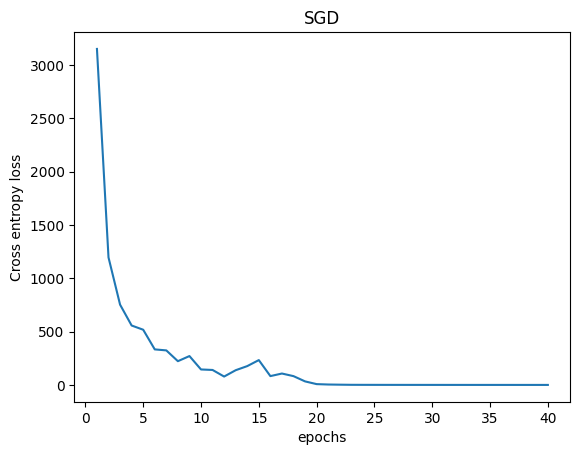

In [101]:
# PLotting error vs epochs
plt.plot([i+1 for i in range(num_epochs_sgd)], losses_sgd)
plt.title("SGD")
plt.xlabel("epochs")
plt.ylabel("Cross entropy loss")
plt.show()

In [102]:
# Testing
test_loader = torch.utils.data.DataLoader(dataset=df_test,batch_size=128,shuffle=True)
tot_loss = 0
good_pred = 0

for i,data in enumerate(test_loader): 
    points = data[:,0:28*28].clone().float().to(device)
    index = (data[:,28*28].clone().long().reshape(-1,1).to(device))
    outputs = one_hot_vec(index, num_classes, points.shape[0]).to(device)
    
    # prediction
    outputs_ = model_sgd.forward_propagation(points)
    outputs_ = torch.softmax(outputs_, dim=1)
    
    
    loss = loss_fn(outputs_,outputs)
    tot_loss += loss.item()

    outputs_ = torch.argmax(outputs_, dim=1).reshape(-1,1)
    good_pred += (outputs_ == index).sum().item()
    
    # print(index,outputs_)
    # print(good_pred)

print(f'Test Loss: {tot_loss}, Accuracy: {100 * good_pred/df_test.shape[0]}')

Test Loss: 27.604779541492462, Accuracy: 98.47167325428195


### FCNN: Vanilla Gradient Descent

In [112]:

# i. Stochastic gradient descent (SGD) algorithm - (batch_size=1),

# Hyper-parameters
input_size = 28*28
hidden_sizes = [64,32,16,8]
num_classes = 5
num_epochs_vanilla = 120
learning_rate = 0.01
batch_size = df_train.shape[0]

# data loader for iteration
train_loader = torch.utils.data.DataLoader(dataset=df_train,batch_size=batch_size,shuffle=True)

# model
model_vanilla = NeuralNet(input_size, hidden_sizes, num_classes).to(device)

# loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vanilla.parameters(),lr=learning_rate)

# Train model
total_steps = len(train_loader)
losses_vanilla = []

for epoch in range(num_epochs_vanilla):
    # each iteration will give a batch of points 

    tot_loss = 0
    for i,data in enumerate(train_loader): 
        points = data[:,0:28*28].clone().float().to(device)
        index = (data[:,28*28].clone().long().reshape(-1,1).to(device))
        outputs = one_hot_vec(index, num_classes, points.shape[0]).to(device)
        
        # forward prop
        outputs_ = model_vanilla.forward_propagation(points)
        loss = loss_fn(outputs_,outputs)

        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print(outputs_, outputs)
        
        tot_loss += loss.item()
 
    losses_vanilla.append(tot_loss)
    
    print (f'Epoch [{epoch+1}/{num_epochs_vanilla}], Loss: {tot_loss}')


Epoch [1/120], Loss: 2.706207275390625
Epoch [2/120], Loss: 1.5436495542526245
Epoch [3/120], Loss: 1.6486144065856934
Epoch [4/120], Loss: 1.557402491569519
Epoch [5/120], Loss: 1.2538280487060547
Epoch [6/120], Loss: 1.0957103967666626
Epoch [7/120], Loss: 1.0118260383605957
Epoch [8/120], Loss: 0.9411813616752625
Epoch [9/120], Loss: 0.8865989446640015
Epoch [10/120], Loss: 0.8498956561088562
Epoch [11/120], Loss: 0.8875317573547363
Epoch [12/120], Loss: 0.986659586429596
Epoch [13/120], Loss: 1.1861839294433594
Epoch [14/120], Loss: 0.8161598443984985
Epoch [15/120], Loss: 0.6798766255378723
Epoch [16/120], Loss: 0.6080778241157532
Epoch [17/120], Loss: 0.5637155771255493
Epoch [18/120], Loss: 0.5294754505157471
Epoch [19/120], Loss: 0.5004618167877197
Epoch [20/120], Loss: 0.475814551115036
Epoch [21/120], Loss: 0.45533281564712524
Epoch [22/120], Loss: 0.4404657185077667
Epoch [23/120], Loss: 0.43489977717399597
Epoch [24/120], Loss: 0.4494950473308563
Epoch [25/120], Loss: 0.514

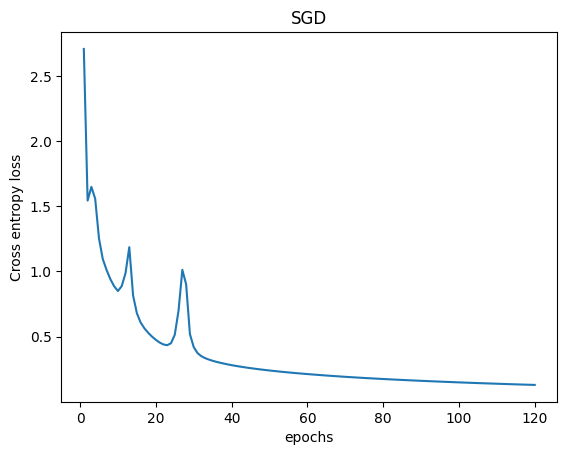

In [113]:
# Plotting error vs epochs
plt.plot([i+1 for i in range(num_epochs_vanilla)], losses_vanilla)
plt.title("SGD")
plt.xlabel("epochs")
plt.ylabel("Cross entropy loss")
plt.show()

In [114]:
# Testing
test_loader = torch.utils.data.DataLoader(dataset=df_test,batch_size=128,shuffle=True)
tot_loss = 0
good_pred = 0

for i,data in enumerate(test_loader): 
    points = data[:,0:28*28].clone().float().to(device)
    index = (data[:,28*28].clone().long().reshape(-1,1).to(device))
    outputs = one_hot_vec(index, num_classes, points.shape[0]).to(device)
    
    # prediction
    outputs_ = model_vanilla.forward_propagation(points)
    outputs_ = torch.softmax(outputs_, dim=1)
    
    
    loss = loss_fn(outputs_,outputs)
    tot_loss += loss.item()

    outputs_ = torch.argmax(outputs_, dim=1).reshape(-1,1)
    good_pred += (outputs_ == index).sum().item()
    
    # print(index,outputs_)
    # print(good_pred)

print(f'Test Loss: {tot_loss}, Accuracy: {100 * good_pred/df_test.shape[0]}')

Test Loss: 29.214185178279877, Accuracy: 95.41501976284584


### FCNN: SGD with momentum

In [106]:
### iii. SGD with momentum (generalized delta rule) – (batch_size=1), 

# Hyper-parameters
input_size = 28*28
hidden_sizes = [64,32,16,8]
num_classes = 5
num_epochs_sgdm = 50
learning_rate = 0.001
batch_size = 64

# data loader for iteration
train_loader = torch.utils.data.DataLoader(dataset=df_train,batch_size=batch_size,shuffle=True)

# model
model_sgdm = NeuralNet(input_size, hidden_sizes, num_classes).to(device)

# loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_sgdm.parameters(),lr=learning_rate,momentum=0.9)

# Train model
total_steps = len(train_loader)
losses_sgdm = []

for epoch in range(num_epochs_sgdm):
    # each iteration will give a batch of points 

    tot_loss = 0
    for i,data in enumerate(train_loader): 
        points = data[:,0:28*28].clone().float().to(device)
        index = (data[:,28*28].clone().long().reshape(-1,1).to(device))
        outputs = one_hot_vec(index, num_classes, points.shape[0]).to(device)
        
        # forward prop
        outputs_ = model_sgdm.forward_propagation(points)
        loss = loss_fn(outputs_,outputs)

        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print(outputs_, outputs)
        
        tot_loss += loss.item()
 
    losses_sgdm.append(tot_loss)
    
    print (f'Epoch [{epoch+1}/{num_epochs_sgdm}], Loss: {tot_loss}')


Epoch [1/50], Loss: 78.48190381750464
Epoch [2/50], Loss: 19.89506139419973
Epoch [3/50], Loss: 14.137500510085374
Epoch [4/50], Loss: 10.254369769943878
Epoch [5/50], Loss: 7.322942303377204
Epoch [6/50], Loss: 5.734325354686007
Epoch [7/50], Loss: 4.6016127386828884
Epoch [8/50], Loss: 4.477833012933843
Epoch [9/50], Loss: 2.288271073746728
Epoch [10/50], Loss: 1.7907797284715343
Epoch [11/50], Loss: 1.726440469341469
Epoch [12/50], Loss: 0.8768416068414808
Epoch [13/50], Loss: 0.5060623760800809
Epoch [14/50], Loss: 0.3921000780828763
Epoch [15/50], Loss: 0.2961489901645109
Epoch [16/50], Loss: 0.23964895963399613
Epoch [17/50], Loss: 0.2204471245786408
Epoch [18/50], Loss: 0.18177411019496503
Epoch [19/50], Loss: 0.16416700861918798
Epoch [20/50], Loss: 0.149935008884313
Epoch [21/50], Loss: 0.13748753261825186
Epoch [22/50], Loss: 0.12661568277690094
Epoch [23/50], Loss: 0.11900879101813189
Epoch [24/50], Loss: 0.11505408676816842
Epoch [25/50], Loss: 0.10678540087064903
Epoch [26

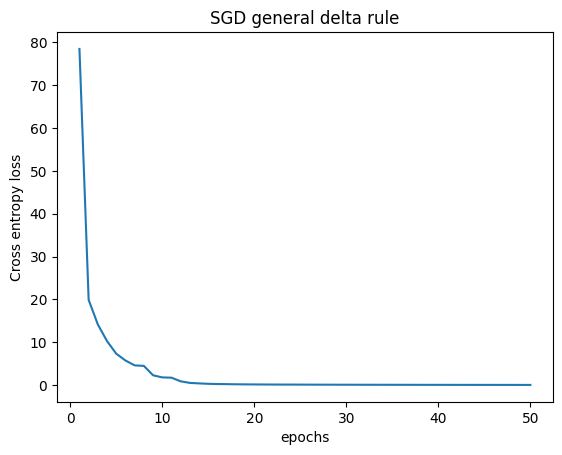

In [107]:
# Plotting error vs epochs
plt.plot([i+1 for i in range(num_epochs_sgdm)], losses_sgdm)
plt.title("SGD general delta rule")
plt.xlabel("epochs")
plt.ylabel("Cross entropy loss")
plt.show()

In [108]:
# Testing
test_loader = torch.utils.data.DataLoader(dataset=df_test,batch_size=128,shuffle=True)
tot_loss = 0
good_pred = 0

for i,data in enumerate(test_loader): 
    points = data[:,0:28*28].clone().float().to(device)
    index = (data[:,28*28].clone().long().reshape(-1,1).to(device))
    outputs = one_hot_vec(index, num_classes, points.shape[0]).to(device)
    
    # prediction
    outputs_ = model_sgdm.forward_propagation(points)
    outputs_ = torch.softmax(outputs_, dim=1)
    
    
    loss = loss_fn(outputs_,outputs)
    tot_loss += loss.item()

    outputs_ = torch.argmax(outputs_, dim=1).reshape(-1,1)
    good_pred += (outputs_ == index).sum().item()
    
    # print(index,outputs_)
    # print(good_pred)

print(f'Test Loss: {tot_loss}, Accuracy: {100 * good_pred/df_test.shape[0]}')

Test Loss: 27.74357908964157, Accuracy: 98.02371541501977


### FCNN: SGD with ADAM

In [33]:
### iii. SGD with momentum (generalized delta rule) – (batch_size=1), 

# Hyper-parameters
input_size = 28*28
hidden_sizes = [64,32,16,8]
num_classes = 5
num_epochs_sgd_adam = 40
learning_rate = 0.001
batch_size = 128

# data loader for iteration
train_loader = torch.utils.data.DataLoader(dataset=df_train,batch_size=batch_size,shuffle=True)

# model
model_sgd_adam = NeuralNet(input_size, hidden_sizes, num_classes).to(device)

# loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_sgd_adam.parameters(),lr=learning_rate)

# Train model
total_steps = len(train_loader)
losses_sgd_adam = []

for epoch in range(num_epochs_sgd_adam):
    # each iteration will give a batch of points 

    tot_loss = 0
    for i,data in enumerate(train_loader): 
        points = data[:,0:28*28].clone().float().to(device)
        index = (data[:,28*28].clone().long().reshape(-1,1).to(device))
        outputs = one_hot_vec(index, num_classes, points.shape[0]).to(device)
        
        # forward prop
        outputs_ = model_sgd_adam.forward_propagation(points)
        loss = loss_fn(outputs_,outputs)

        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print(outputs_, outputs)
        
        tot_loss += loss.item()
 
    losses_sgd_adam.append(tot_loss)
    
    print (f'Epoch [{epoch+1}/{num_epochs_sgd_adam}], Loss: {tot_loss}')


Epoch [1/40], Loss: 44.25825559347868
Epoch [2/40], Loss: 10.14367588609457
Epoch [3/40], Loss: 6.2818189933896065
Epoch [4/40], Loss: 4.189339219592512
Epoch [5/40], Loss: 2.8172045219689608
Epoch [6/40], Loss: 1.302090829005465
Epoch [7/40], Loss: 1.383857045089826
Epoch [8/40], Loss: 1.0953384232707322
Epoch [9/40], Loss: 0.8436797464091796
Epoch [10/40], Loss: 1.4093882243032567
Epoch [11/40], Loss: 0.8149862213758752
Epoch [12/40], Loss: 0.7569510574903688
Epoch [13/40], Loss: 1.4357512748101726
Epoch [14/40], Loss: 1.3964037320693024
Epoch [15/40], Loss: 0.9324034136516275
Epoch [16/40], Loss: 0.5994639549171552
Epoch [17/40], Loss: 1.2193356801144546
Epoch [18/40], Loss: 0.46816241755732335
Epoch [19/40], Loss: 0.1254783884196513
Epoch [20/40], Loss: 0.028678928345470922
Epoch [21/40], Loss: 0.012486812252973323
Epoch [22/40], Loss: 0.009790882982088078
Epoch [23/40], Loss: 0.008034636138290807
Epoch [24/40], Loss: 0.006809381979110185
Epoch [25/40], Loss: 0.005887616247491678
E

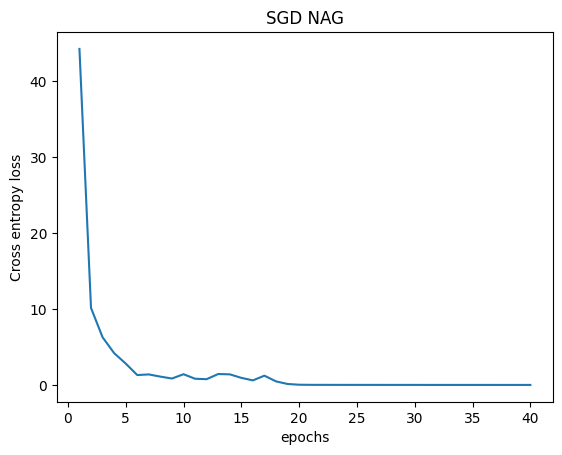

In [34]:
# Plotting error vs epochs
plt.plot([i+1 for i in range(num_epochs_sgd_adam)], losses_sgd_adam)
plt.title("SGD NAG")
plt.xlabel("epochs")
plt.ylabel("Cross entropy loss")
plt.show()

In [35]:
# Testing
test_loader = torch.utils.data.DataLoader(dataset=df_test,batch_size=128,shuffle=True)
tot_loss = 0
good_pred = 0

for i,data in enumerate(test_loader): 
    points = data[:,0:28*28].clone().float().to(device)
    index = (data[:,28*28].clone().long().reshape(-1,1).to(device))
    outputs = one_hot_vec(index, num_classes, points.shape[0]).to(device)
    
    # prediction
    outputs_ = model_sgd_adam.forward_propagation(points)
    outputs_ = torch.softmax(outputs_, dim=1)
    
    loss = loss_fn(outputs_,outputs)
    tot_loss += loss.item()

    outputs_ = torch.argmax(outputs_, dim=1).reshape(-1,1)
    good_pred += (outputs_ == index).sum().item()
    
    # print(index,outputs_)
    # print(good_pred)

print(f'Test Loss: {tot_loss}, Accuracy: {100 * good_pred/df_test.shape[0]}')


Test Loss: 27.62303251028061, Accuracy: 98.36627140974967


In [3]:
test_loader = torch.utils.data.DataLoader(dataset=df_test,batch_size=batch_size,shuffle=True)

id = 1513
plt.imshow( np.array(test_loader.dataset[id,:28*28].reshape(28,28)), cmap="gray")
y = torch.argmax(model_sgd_adam.forward_propagation(test_loader.dataset[id,0:28*28].clone().float().to(device))).item()
print(dict[y])

NameError: name 'torch' is not defined